# Plan

0. *Boost training data (if using supervised learning)*
1. Standarize data
2. Calculate covariance AKA scatter matrix
3. Obtain principal components (calculate eigens and order by value descending)
4. Formalize feature vector (pick # of components to keep)
5. Transform/ recast data

In [168]:
# imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("default")
plt.style.use("tableau-colorblind10")
plt.rc('patch', edgecolor='w')

from numpy.random import seed

In [169]:
# check current directory
import pathlib
pathlib.Path.cwd()

PosixPath('/Users/viv/Documents/Code/AnomalyDetectionPCADemo')

## Data preprocessing

In [170]:
data_dir = 'sample_data'
filename = 'creditcardfraud_orig.csv'

#dataset = pd.read_csv(os.path.join(data_dir, filename))
dataset = pd.read_csv(filename)
dataset

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.756448,0.873531,0.666991,0.160317,0.729603,0.236810,0.235393,0.863749,0.528729,0.598850,...,0.564920,0.515249,0.680500,0.313600,0.658558,0.466291,0.433929,0.329840,0.000030,0
284803,0.945845,0.766677,0.872678,0.219189,0.771561,0.273661,0.265504,0.788548,0.482925,0.488530,...,0.564933,0.553154,0.665619,0.245298,0.543855,0.360884,0.417775,0.312038,0.000965,0
284804,0.990905,0.764080,0.781102,0.227202,0.783425,0.293496,0.263547,0.792985,0.477677,0.498692,...,0.565220,0.537005,0.664877,0.468492,0.592823,0.411176,0.416593,0.312585,0.002642,0
284805,0.954209,0.772856,0.849587,0.282508,0.763172,0.269291,0.261175,0.792671,0.476287,0.500464,...,0.565755,0.547353,0.663008,0.398836,0.545958,0.514746,0.418520,0.315245,0.000389,0


### Split test train & Normalize

In [171]:
scaler = preprocessing.MinMaxScaler()

dataset_train = dataset[ dataset['class']==0 ]
dataset_test = dataset[ dataset['class']==1 ]

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

## Get principal components

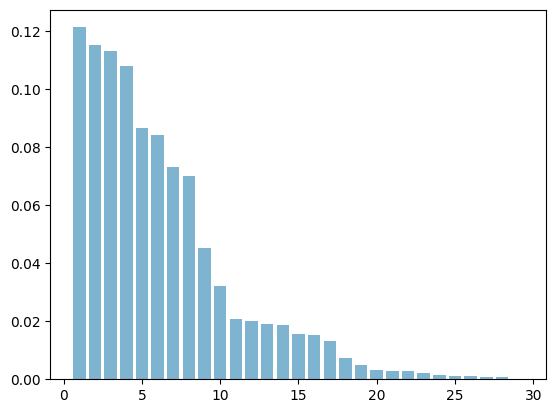

In [172]:
from sklearn.decomposition import PCA

# check variance explained
pca = PCA(n_components = 'mle', svd_solver= 'full')
pca.fit(X_train)

var_explained = pca.explained_variance_ratio_
plt.bar(np.arange(1,len(var_explained)+1), var_explained, align='center', alpha=0.5)
plt.show()

# subset components & transform
pca = PCA(n_components = 8, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

## Calculate M-Distance

### Define functions
See reference [1]

In [173]:
mean_distr = data_train.mean(axis=0)

# Calculate the covariance matrix:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    return covariance_matrix, np.linalg.inv(covariance_matrix)

# Calculate the Mahalanobis distance:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

# Detecting outliers:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

# Calculate threshold value for classifying datapoint as anomaly:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

### Calculations
see reference [1]

<AxesSubplot:>

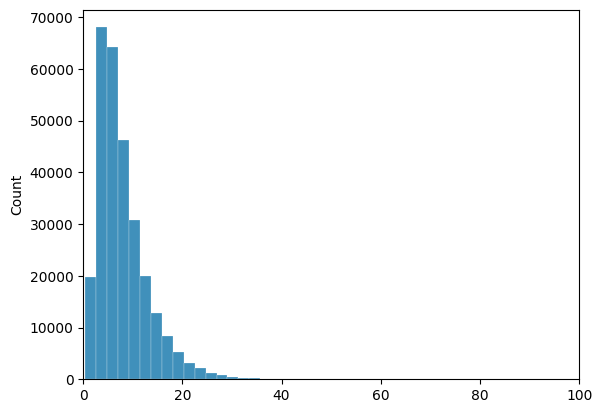

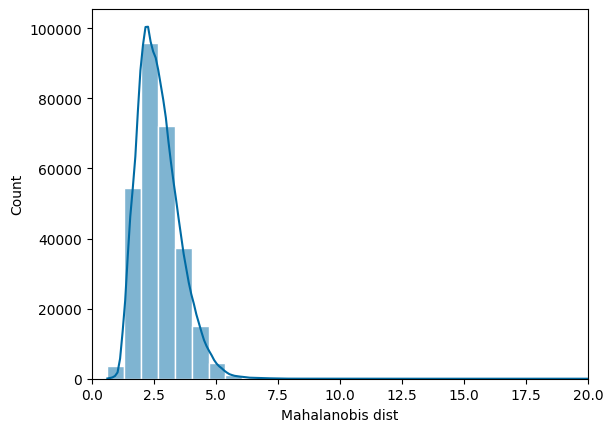

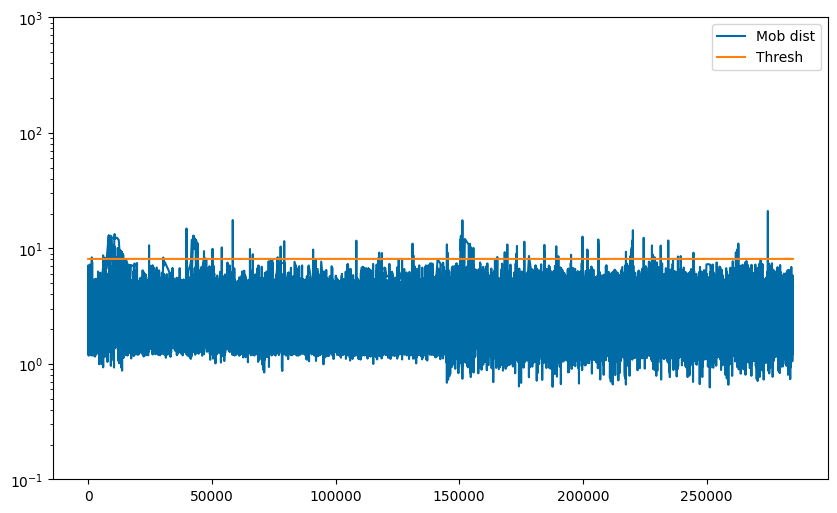

In [174]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

# Calculate the covariance matrix and its inverse, based on data in the training set:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

# We also calculate the mean value for the input variables in the training set, as this is used later to calculate the Mahalanobis distance to datapoints in the test set
mean_distr = data_train.mean(axis=0)

# Using the covariance matrix and its inverse, we can calculate the Mahalanobis distance for the training data defining “normal conditions”, and find the threshold value to flag datapoints as an anomaly. One can then calculate the Mahalanobis distance for the datapoints in the test set, and compare that with the anomaly threshold.
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

# Threshold value for flagging an anomaly:
# The square of the Mahalanobis distance to the centroid of the distribution should follow a χ2 distribution if the assumption of normal distributed input variables is fulfilled. This is also the assumption behind the above calculation of the “threshold value” for flagging an anomaly. As this assumption is not necessarily fulfilled in our case, it is beneficial to visualize the distribution of the Mahalanobis distance to set a good threshold value for flagging anomalies. Again, I refer to my previous article, for a more detailed introduction to these technical aspects.
# We start by visualizing the square of the Mahalanobis distance, which should then ideally follow a χ2 distribution.
plt.figure()
sns.histplot(np.square(dist_train),
             bins = 200,
             kde= False);
plt.xlim([0.0,100])
###savefig('demo.png', transparent=True)

# Square of the Mahalanobis distance
# Then visualize the Mahalanobis distance itself:
plt.figure()
sns.histplot(dist_train,
             bins = 30,
             kde= True);
plt.xlim([0.0,20])
plt.xlabel('Mahalanobis dist')

# From the above distributions, the calculated threshold value of 3.8 for flagging an anomaly seems reasonable (defined as 3 standard deviations from the center of the distribution)
# We can then save the Mahalanobis distance, as well as the threshold value and “anomaly flag” variable for both train and test data in a dataframe:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

# Resulting dataframe for the test data
# Based on the calculated statistics, any distance above the threshold value will be flagged as an anomaly.
# We can now merge the data in a single dataframe and save it as a .csv file:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

# Verifying PCA model on test data:
# We can now plot the calculated anomaly metric (Mob dist), and check when it crosses the anomaly threshold (note the logarithmic y-axis).
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3])

In [175]:
style_list = ['default', 'classic'] + sorted(
        style for style in plt.style.available if style != 'classic')
style_list

['default',
 'classic',
 'Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

# References
[1] https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770